In [1]:
import torchvision
import tqdm
import PIL.Image
import os
import torch.nn.functional as F
from tqdm import trange
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

assert torch.cuda.is_available(), "Should use GPU-enabled colab"
device = torch.device('cuda:0')  # we will train with CUDA!

In [2]:
class CelebA_dataset(Dataset):
    def __init__(self, root_dir, mode='train',
                 transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                           torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])):
        self.root_dir = root_dir
        self.path_to_imgs = os.path.join(self.root_dir, mode)
        self.transform = transform
        self.image_files = sorted(os.listdir(self.path_to_imgs))

        self.labels = np.load(os.path.join(self.root_dir, f'labels_{mode}.npy'))

    def __len__(self):
        return len(self.image_files)


    def __getitem__(self, idx):
        img_name = os.path.join(self.path_to_imgs, self.image_files[idx])
        image = PIL.Image.open(img_name)
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

In [3]:
data_train_base = CelebA_dataset('drive/MyDrive/celeba_domain_base/', 'train')
data_train_sketch = CelebA_dataset('drive/MyDrive/celeba_domain_train_and_test_sketched/', 'train')
data_test_base = CelebA_dataset('drive/MyDrive/celeba_domain_base/', 'test')
data_test_sketch = CelebA_dataset('drive/MyDrive/celeba_domain_train_and_test_sketched/', 'test')

In [4]:
class BinaryClassifierCNN(nn.Module):
    def __init__(self):
        super(BinaryClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)  # Adjust according to the output of the last conv layer
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = nn.functional.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Using sigmoid for binary classification
        return x

In [5]:
train_loader_base = DataLoader(data_train_base, batch_size=32, shuffle=False)
train_loader_sketch = DataLoader(data_train_sketch, batch_size=32, shuffle=False)
test_loader_base = DataLoader(data_test_base, batch_size=32, shuffle=False)
test_loader_sketch = DataLoader(data_test_sketch, batch_size=32, shuffle=False)

### Train on base domain

In [79]:
model = BinaryClassifierCNN()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [81]:
# Variables to store performance metrics
train_losses = []
test_losses_base = []
test_losses_sketch = []
train_accuracies = []
test_accuracies_base = []
test_accuracies_sketch = []

# Training and Evaluation Loop
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    # Training
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader_base:
        labels = labels.float()
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        predicted = outputs.round()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss / len(train_loader_base))
    train_accuracies.append(100 * correct_train / total_train)

    # Testing
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader_base:
            labels = labels.float()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predicted = outputs.round()
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_losses_base.append(test_loss / len(test_loader_base))
    test_accuracies_base.append(100 * correct_test / total_test)

    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader_sketch:
            labels = labels.float()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predicted = outputs.round()
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_losses_sketch.append(test_loss / len(test_loader_sketch))
    test_accuracies_sketch.append(100 * correct_test / total_test)

    print(f"Epoch: {epoch+1}, Train Acc {train_accuracies[-1]}, Test Acc Base {test_accuracies_base[-1]}, Test Acc Sketch {test_accuracies_sketch[-1]}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1, Train Acc 62.833333333333336, Test Acc Base 75.33333333333333, Test Acc Sketch 67.0
Epoch: 2, Train Acc 81.08333333333333, Test Acc Base 73.33333333333333, Test Acc Sketch 71.33333333333333
Epoch: 3, Train Acc 87.83333333333333, Test Acc Base 88.66666666666667, Test Acc Sketch 59.0
Epoch: 4, Train Acc 92.33333333333333, Test Acc Base 87.66666666666667, Test Acc Sketch 57.666666666666664
Epoch: 5, Train Acc 94.41666666666667, Test Acc Base 88.66666666666667, Test Acc Sketch 60.666666666666664
Epoch: 6, Train Acc 98.16666666666667, Test Acc Base 88.0, Test Acc Sketch 62.333333333333336
Epoch: 7, Train Acc 98.58333333333333, Test Acc Base 89.0, Test Acc Sketch 53.666666666666664
Epoch: 8, Train Acc 99.33333333333333, Test Acc Base 90.33333333333333, Test Acc Sketch 55.0
Epoch: 9, Train Acc 100.0, Test Acc Base 89.33333333333333, Test Acc Sketch 55.0
Epoch: 10, Train Acc 99.91666666666667, Test Acc Base 89.0, Test Acc Sketch 59.333333333333336


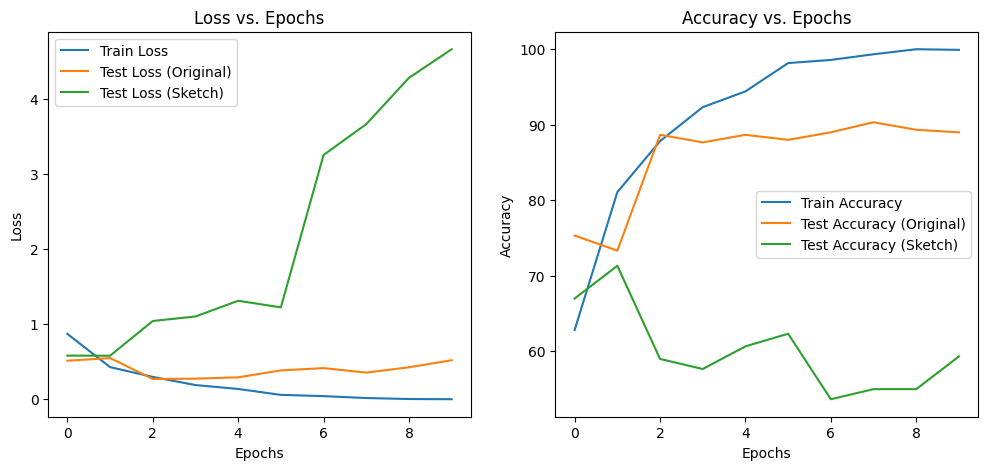

In [82]:
# Plotting the training and test curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses_base, label='Test Loss (Original)')
plt.plot(test_losses_sketch, label='Test Loss (Sketch)')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies_base, label='Test Accuracy (Original)')
plt.plot(test_accuracies_sketch, label='Test Accuracy (Sketch)')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Train on shifted domain

In [6]:
model = BinaryClassifierCNN()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Variables to store performance metrics
train_losses_sketch = []
test_losses_base = []
test_losses_sketch = []
train_accuracies_sketch = []
test_accuracies_base = []
test_accuracies_sketch = []

# Training and Evaluation Loop
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    # Training
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader_sketch:
        labels = labels.float()
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        predicted = outputs.round()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        loss.backward()
        optimizer.step()
    train_losses_sketch.append(train_loss / len(train_loader_sketch))
    train_accuracies_sketch.append(100 * correct_train / total_train)

    # Testing
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader_base:
            labels = labels.float()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predicted = outputs.round()
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_losses_base.append(test_loss / len(test_loader_base))
    test_accuracies_base.append(100 * correct_test / total_test)

    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader_sketch:
            labels = labels.float()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predicted = outputs.round()
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_losses_sketch.append(test_loss / len(test_loader_sketch))
    test_accuracies_sketch.append(100 * correct_test / total_test)

    print(f"Epoch: {epoch+1}, Train Acc {train_accuracies_sketch[-1]}, Test Acc Base {test_accuracies_base[-1]}, Test Acc Sketch {test_accuracies_sketch[-1]}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1, Train Acc 59.083333333333336, Test Acc Base 66.33333333333333, Test Acc Sketch 68.66666666666667
Epoch: 2, Train Acc 72.66666666666667, Test Acc Base 73.66666666666667, Test Acc Sketch 77.33333333333333
Epoch: 3, Train Acc 80.25, Test Acc Base 74.66666666666667, Test Acc Sketch 81.0
Epoch: 4, Train Acc 84.5, Test Acc Base 73.0, Test Acc Sketch 82.33333333333333
Epoch: 5, Train Acc 87.66666666666667, Test Acc Base 75.0, Test Acc Sketch 86.0
Epoch: 6, Train Acc 92.33333333333333, Test Acc Base 71.33333333333333, Test Acc Sketch 86.0
Epoch: 7, Train Acc 92.58333333333333, Test Acc Base 73.33333333333333, Test Acc Sketch 87.0
Epoch: 8, Train Acc 93.16666666666667, Test Acc Base 78.66666666666667, Test Acc Sketch 85.66666666666667
Epoch: 9, Train Acc 96.58333333333333, Test Acc Base 72.0, Test Acc Sketch 88.0
Epoch: 10, Train Acc 97.08333333333333, Test Acc Base 71.0, Test Acc Sketch 87.0


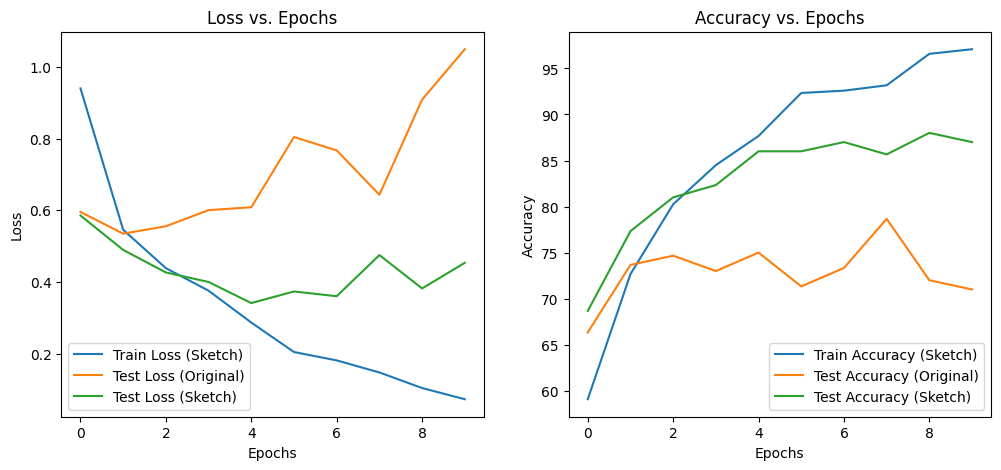

In [8]:
# Plotting the training and test curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_sketch, label='Train Loss (Sketch)')
plt.plot(test_losses_base, label='Test Loss (Original)')
plt.plot(test_losses_sketch, label='Test Loss (Sketch)')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_sketch, label='Train Accuracy (Sketch)')
plt.plot(test_accuracies_base, label='Test Accuracy (Original)')
plt.plot(test_accuracies_sketch, label='Test Accuracy (Sketch)')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()